# Cellular model of weathering starting from a flat surface

This notebook runs the Grain Hill model with an initially flat surface and "walls" on either boundary, to explore what happens when you have weathering without any net erosion or deposition.

Start with some imports...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, set up model parameters in a dictionary:

In [2]:
# Dictionary for parameters
params = {}

num_cols = 401
params['number_of_node_columns'] = num_cols
num_rows = 41
params['number_of_node_rows'] = num_rows
params['disturbance_rate'] = 0.01
params['uplift_interval'] = 1.0e10
params['weathering_rate'] = 0.01
params['run_duration'] = 4000.0
params['show_plots'] = False
params['plot_interval'] = 40.0
params['output_interval'] = 1.1 * params['run_duration']
params['report_interval'] = 20.0
params['settling_rate'] = 220000000.0
params['friction_coef'] = 1.0
params['rock_state_for_uplift'] = 8
params['opt_rock_collapse'] = 1.0
params['plot_every_transition'] = False

To set up the starting grid, we'll use the admittedly clunky trick of creating a Landlab hex grid simply for the sake of knowing the $(x,y)$ coordinates of the nodes in the grid we will *actually* use in the Grain Hill model. We do it this way because we need to have the node-state values already defined when we create the Grain Hill model instance. The setup here has the grid half full of rock cells, with high walls of rock on the left and right boundaries.

In [13]:
from landlab import HexModelGrid

grid = HexModelGrid(num_rows, num_cols, orientation='vert', shape='rect')
ns = np.zeros(grid.number_of_nodes, dtype=int)
bottom_half = np.where(grid.y_of_node < 0.5 * num_rows)[0]
ns[bottom_half] = 8
left_edge = np.where(grid.x_of_node == 0.0)[0]
ns[left_edge] = 8
right_edge = np.where(grid.x_of_node > 0.866 * num_cols - 1.0)[0]
ns[right_edge] = 8

# Keep a copy of the original node state grid for reuse
ns_original = ns.copy()
params['initial_state_grid'] = ns_original

Plot the initial condition

(-17.955593371797363,
 364.36575488557281,
 -2.5749999999999997,
 43.074999999999996)

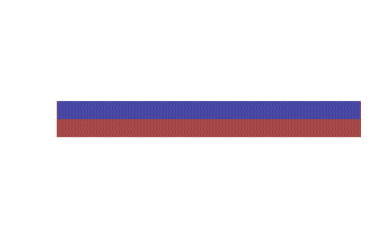

In [4]:
ax = grid.hexplot(ns)
plt.axis('equal')
plt.axis('off')

Because we'll want to run the model several times, using different disturbance rates, we'll create a function to do so. It takes *params* as an argument, and through this dict we can set our desired disturbance and weathering rates.

In [5]:
def run_flat_surface_weathering(params, niter):
    """Run weathering and disturbance starting with a flat surface."""
    import grain_hill_as_class

    # instantiate a GrainHill model
    num_rows = params['number_of_node_rows']
    num_cols = params['number_of_node_columns']
    grain_hill = grain_hill_as_class.GrainHill((num_rows, num_cols), **params)
    
    dt = params['run_duration'] / float(niter)

    soil_thickness = np.zeros(niter + 1)
    
    for i in range(niter):
        
        grain_hill.run_for(dt)

        # compute and write the results
        (elev_profile, soil) = grain_hill.get_profile_and_soil_thickness(grain_hill.grid, 
                                                                 grain_hill.ca.node_state)
        #plot_hill(grain_hill.ca.grid)
        soil_thickness[i+1] = np.mean(soil)

    return np.arange(0.0, dt * niter + 2, dt), soil_thickness

Now let's give it a try, initially with zero disturbance rate:

In [6]:
params['disturbance_rate'] = 0.0
(t, H0) = run_flat_surface_weathering(params, 1000)

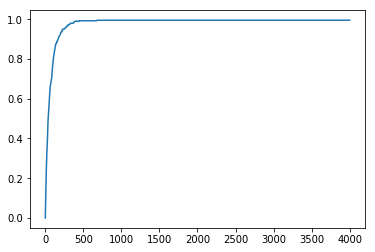

In [7]:
plt.plot(t, H0)

Now, we'll do a set of experimental runs in which the ratio of disturbance to weathering rate ranges 0.1, 1.0, 10.0 (this takes a few minutes to run).

In [8]:
params['disturbance_rate'] = 0.001
(t, H0p001) = run_flat_surface_weathering(params, 1000)
params['disturbance_rate'] = 0.01
(t, H0p01) = run_flat_surface_weathering(params, 1000)
params['disturbance_rate'] = 0.1
(t, H0p1) = run_flat_surface_weathering(params, 1000)

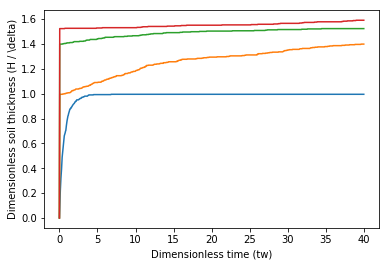

In [10]:
w = 0.01
plt.plot(t * w, H0)
plt.plot(t * w, H0p001)
plt.plot(t * w, H0p01)
plt.plot(t * w, H0p1)
plt.xlabel('Dimensionless time (tw)')
plt.ylabel('Dimensionless soil thickness (H / \delta)')
#plt.legend('d/w = 0', 'd/w = 0.1', 'd/w = 1', 'd/w = 10')

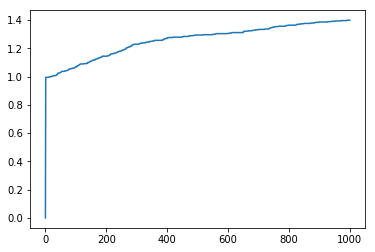

In [11]:
plt.plot(H0p001)